<a href="https://colab.research.google.com/github/emarttila/Koodausnaytteet/blob/main/Koneoppiminen_ja_datan_analysointi_(Student_Performance_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Aineistona on portugalilaisen koulun oppilailta kerättyjä tietoja. Kerättyjen tietojen vaikutusta oppilaiden loppuarvosanaan matematiikassa (G3) pyrittiin hahmottamaan ja ennustamaan. Mukana ovat myös väliarvosanat G1 ja G2.**


*P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7. *

In [ ]:
#Tuodaan tarvittavat kirjastot.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Avataan aineisto.
dataset = pd.read_csv("student-mat.csv", sep = ';')

In [ ]:
#Katsotaan aineiston yleisilme.
print(dataset.head())
print(dataset.info())

  school sex  age address famsize Pstatus  ...  Walc  health absences  G1  G2  G3
0     GP   F   18       U     GT3       A  ...     1       3        6   5   6   6
1     GP   F   17       U     GT3       T  ...     1       3        4   5   5   6
2     GP   F   15       U     LE3       T  ...     3       3       10   7   8  10
3     GP   F   15       U     GT3       T  ...     1       5        2  15  14  15
4     GP   F   16       U     GT3       T  ...     2       5        4   6  10  10

[5 rows x 33 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school      395 non-null    category
 1   sex         395 non-null    category
 2   age         395 non-null    int64   
 3   address     395 non-null    category
 4   famsize     395 non-null    category
 5   Pstatus     395 non-null    category
 6   Medu        395 non-null    int64   
 7

In [ ]:
#Katsotaan onko aineistossa puuttuvia arvoja (ei ole).
dataset.isnull().sum().sum()

0

In [ ]:
#Muutetaan objekti- datatyypit kategorioiksi.
for i in dataset.columns:
  if dataset[i].dtype == 'O':
    dataset[i] = dataset[i].astype('category')

In [ ]:
#Tarkastellaan korrelaatioita aineistosta G3:n eli lopullisen arvosanan kanssa. 
korrelaatio = dataset.corr()
korrelaatio['G3'].sort_values(ascending=False)

G3            1.000000
G2            0.904868
G1            0.801468
Medu          0.217147
Fedu          0.152457
studytime     0.097820
famrel        0.051363
absences      0.034247
freetime      0.011307
Walc         -0.051939
Dalc         -0.054660
health       -0.061335
traveltime   -0.117142
goout        -0.132791
age          -0.161579
failures     -0.360415
Name: G3, dtype: float64

AttributeError: ignored

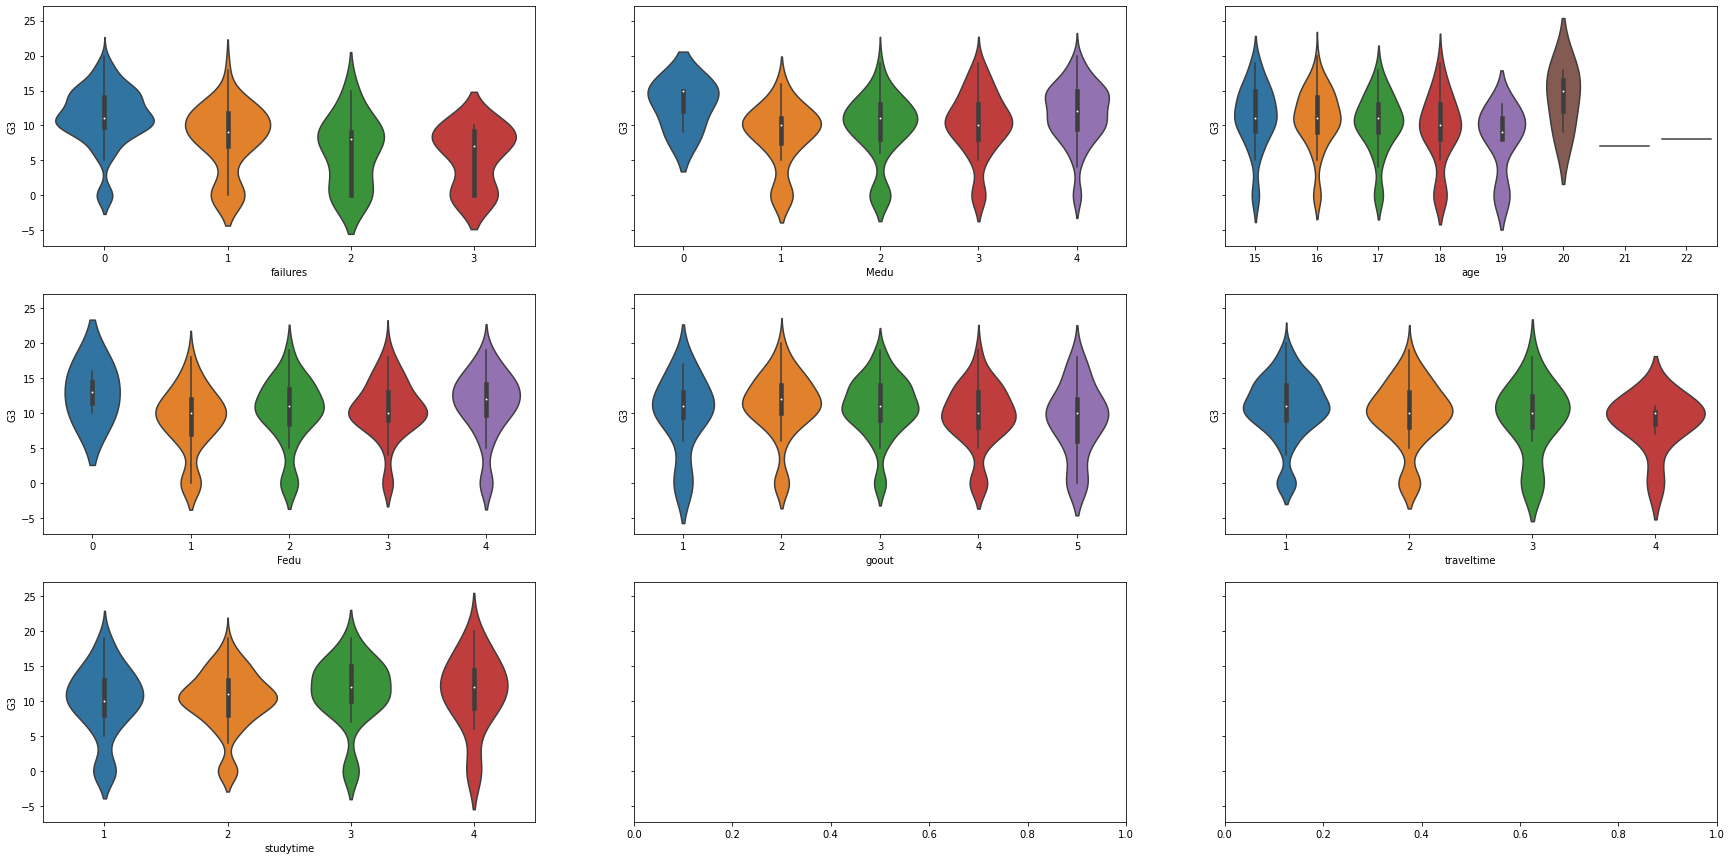

In [ ]:
#Valitaan aineistosta muuttujat, joiden korrelaation itseisarvo G3:n kanssa on vähintään 0,09. G2 ja G1 jätetään pois, koska ne ovat väliarvosanoja ja niillä on suuri vaikutus lopulliseen arvosanaan. Piirretään kuvaajaan jokainen muuttuja ja sen yhteys G3:n.
f, ax = plt.subplots(3,3, figsize = (30,15), sharex=False, sharey=True,)
failures = sns.violinplot(dataset['failures'], dataset['G3'], ax=ax[0][0])
Medu = sns.violinplot(dataset['Medu'], dataset['G3'], ax=ax[0][1])
age = sns.violinplot(dataset['age'], dataset['G3'], ax=ax[0][2])
Fedu = sns.violinplot(dataset['Fedu'], dataset['G3'], ax=ax[1][0])
goout = sns.violinplot(dataset['goout'], dataset['G3'], ax=ax[1][1])
traveltime = sns.violinplot(dataset['traveltime'], dataset['G3'], ax=ax[1][2])
studytime = sns.violinplot(dataset['studytime'], dataset['G3'], ax=ax[2][0])


In [ ]:
#Jaetaan aineisto riippumattomiin ja riippuvaan muuttujaa. Jätetään G1 ja G2 eli väliarvosanat pois kokonaan.
X = dataset.iloc[:, :-3].values
y = dataset.iloc[:, -1].values

In [ ]:
#Koodataan kategoriset muuttujat OneHotEncoderilla.
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,1,3,4,5,8,9,10,11,15,16,17,18,19,20,21,22])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [ ]:
#Jaetaan havainnot training ja test settiin.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
#Käytetään XGboostia regressiomallin luomiseen ja loppukokeen tuloksen ennustamiseen.
from xgboost import XGBRegressor
regressor = XGBRegressor()
regressor.fit(X_train, y_train)

[12:48:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
#Taulukoidaan vierekkäin ennustettu ja testisetin todellinen arvo.
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[12.27 14.  ]
 [ 8.06 10.  ]
 [10.57  9.  ]
 [13.33 15.  ]
 [12.52 16.  ]
 [12.88 12.  ]
 [ 6.33 14.  ]
 [11.46 11.  ]
 [11.03  9.  ]
 [12.43 15.  ]
 [10.95 10.  ]
 [ 8.14 11.  ]
 [13.14 10.  ]
 [11.59  8.  ]
 [13.04 15.  ]
 [13.25 14.  ]
 [ 9.76 12.  ]
 [ 8.79  0.  ]
 [11.84 10.  ]
 [11.87 16.  ]
 [ 6.24  0.  ]
 [ 1.65  0.  ]
 [ 9.84  8.  ]
 [11.08 16.  ]
 [10.47 12.  ]
 [15.61 15.  ]
 [11.18 10.  ]
 [13.97 19.  ]
 [11.29  0.  ]
 [13.8  14.  ]
 [ 1.23  0.  ]
 [ 8.89 10.  ]
 [13.34  8.  ]
 [ 8.85  4.  ]
 [15.42 13.  ]
 [ 7.92 10.  ]
 [13.21 13.  ]
 [12.03 18.  ]
 [ 9.57  8.  ]
 [ 8.83 11.  ]
 [ 9.44  6.  ]
 [11.66 18.  ]
 [ 8.56  8.  ]
 [11.08  8.  ]
 [10.11 11.  ]
 [ 1.49  0.  ]
 [12.3  13.  ]
 [ 2.17  0.  ]
 [12.06 13.  ]
 [ 2.34  7.  ]
 [12.03 10.  ]
 [14.47 18.  ]
 [10.97 10.  ]
 [10.31  9.  ]
 [12.3  11.  ]
 [10.88  6.  ]
 [11.72  9.  ]
 [ 6.69 13.  ]
 [11.43 15.  ]
 [ 9.03 14.  ]
 [15.24 14.  ]
 [13.31 15.  ]
 [12.25 14.  ]
 [11.28 15.  ]
 [12.73  0.  ]
 [12.37 15.  ]
 [11.32 19

In [ ]:
#Katsotaan ennustuksen tarkkuus R2 testillä. Heikolta näyttää. Entä jos väliarvosanat ovat mukana?
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.2690986585176638

In [ ]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,1,3,4,5,8,9,10,11,15,16,17,18,19,20,21,22])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
from xgboost import XGBRegressor
regressor = XGBRegressor()
regressor.fit(X_train, y_train)

[12:54:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
#Jos väliarvosanat otetaan mukaan, niin mallin ennustuksen tarkkuus paranee huimasti.
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.8615536471913244